In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# CausalML imports (for uplift models only - metrics implemented manually)
from causalml.inference.meta import BaseTClassifier, BaseSClassifier, BaseXClassifier

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

%matplotlib inline

print("✅ Libraries loaded successfully!")


✅ CausalML and dependencies loaded successfully!


In [2]:
# Load data
df = pd.read_parquet('../data/raw/criteo_uplift.parquet')
print(f"Full dataset: {df.shape[0]:,} rows")

# Sample for faster training (adjust based on your compute resources)
SAMPLE_SIZE = 300_000
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
print(f"Sample size: {df_sample.shape[0]:,} rows")

# Define features and targets
feature_cols = [f'f{i}' for i in range(12)]
X = df_sample[feature_cols].values
y = df_sample['conversion'].values
treatment = df_sample['treatment'].values

print(f"\nFeatures: {len(feature_cols)}")
print(f"Treatment rate: {treatment.mean()*100:.1f}%")
print(f"Conversion rate: {y.mean()*100:.3f}%")


Full dataset: 13,979,592 rows
Sample size: 300,000 rows

Features: 12
Treatment rate: 85.0%
Conversion rate: 0.313%


In [3]:
# Train/Test split
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, treatment, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Stratify by outcome due to class imbalance
)

print(f"Training set: {len(X_train):,} rows")
print(f"Test set: {len(X_test):,} rows")
print(f"\nTraining - Treatment: {t_train.mean()*100:.1f}%, Conversion: {y_train.mean()*100:.3f}%")
print(f"Test - Treatment: {t_test.mean()*100:.1f}%, Conversion: {y_test.mean()*100:.3f}%")


Training set: 210,000 rows
Test set: 90,000 rows

Training - Treatment: 84.9%, Conversion: 0.313%
Test - Treatment: 85.0%, Conversion: 0.312%


In [4]:
# T-Learner with XGBoost as base model
base_learner_t = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

learner_t = BaseTClassifier(learner=base_learner_t)

print("Training T-Learner...")
learner_t.fit(X=X_train, treatment=t_train, y=y_train)

# Predict uplift (CATE - Conditional Average Treatment Effect)
uplift_t = learner_t.predict(X=X_test, treatment=t_test).flatten()

print(f"\n✅ T-Learner trained!")
print(f"Uplift predictions on test set:")
print(f"  Mean: {uplift_t.mean()*100:.4f}%")
print(f"  Std:  {uplift_t.std()*100:.4f}%")
print(f"  Range: [{uplift_t.min()*100:.4f}%, {uplift_t.max()*100:.4f}%]")


Training T-Learner...

✅ T-Learner trained!
Uplift predictions on test set:
  Mean: 0.1774%
  Std:  1.7261%
  Range: [-65.6058%, 65.2421%]


In [5]:
# S-Learner with XGBoost
base_learner_s = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

learner_s = BaseSClassifier(learner=base_learner_s)

print("Training S-Learner...")
learner_s.fit(X=X_train, treatment=t_train, y=y_train)

# Predict uplift
uplift_s = learner_s.predict(X=X_test, treatment=t_test).flatten()

print(f"\n✅ S-Learner trained!")
print(f"Uplift predictions on test set:")
print(f"  Mean: {uplift_s.mean()*100:.4f}%")
print(f"  Std:  {uplift_s.std()*100:.4f}%")
print(f"  Range: [{uplift_s.min()*100:.4f}%, {uplift_s.max()*100:.4f}%]")


Training S-Learner...

✅ S-Learner trained!
Uplift predictions on test set:
  Mean: 0.1016%
  Std:  0.6381%
  Range: [-10.6856%, 26.0563%]


In [6]:
# X-Learner with XGBoost
# X-Learner requires:
#   - outcome_learner: Classifier (predicts P(Y|X))
#   - effect_learner: REGRESSOR (predicts continuous treatment effect)
outcome_learner_x = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)

# Effect learner must be a REGRESSOR because it predicts continuous CATE values
effect_learner_x = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

learner_x = BaseXClassifier(
    outcome_learner=outcome_learner_x,
    effect_learner=effect_learner_x
)

print("Training X-Learner...")
learner_x.fit(X=X_train, treatment=t_train, y=y_train)

# Predict uplift
uplift_x = learner_x.predict(X=X_test, treatment=t_test).flatten()

print(f"\n✅ X-Learner trained!")
print(f"Uplift predictions on test set:")
print(f"  Mean: {uplift_x.mean()*100:.4f}%")
print(f"  Std:  {uplift_x.std()*100:.4f}%")
print(f"  Range: [{uplift_x.min()*100:.4f}%, {uplift_x.max()*100:.4f}%]")

Training X-Learner...

✅ X-Learner trained!
Uplift predictions on test set:
  Mean: 0.1205%
  Std:  1.6495%
  Range: [-58.2370%, 59.4819%]


## 5. Model Comparison - Store Predictions

In [7]:
# Create DataFrame with all predictions for comparison
results_df = pd.DataFrame({
    'y_true': y_test,
    'treatment': t_test,
    'uplift_t_learner': uplift_t,
    'uplift_s_learner': uplift_s,
    'uplift_x_learner': uplift_x
})

# Summary statistics
print("=" * 60)
print("MODEL COMPARISON - Uplift Prediction Summary")
print("=" * 60)

for model in ['t_learner', 's_learner', 'x_learner']:
    col = f'uplift_{model}'
    print(f"\n{model.upper()}:")
    print(f"  Mean uplift: {results_df[col].mean()*100:.4f}%")
    print(f"  Std: {results_df[col].std()*100:.4f}%")
    
results_df.head(10)

MODEL COMPARISON - Uplift Prediction Summary

T_LEARNER:
  Mean uplift: 0.1774%
  Std: 1.7261%

S_LEARNER:
  Mean uplift: 0.1016%
  Std: 0.6381%

X_LEARNER:
  Mean uplift: 0.1205%
  Std: 1.6495%


,y_true,treatment,uplift_t_learner,uplift_s_learner,uplift_x_learner
0,0,1,0.000181,8.072756e-05,0.000854
1,0,1,0.000973,7.674730e-04,0.000399
2,0,1,0.000756,1.119659e-04,0.000201
3,0,1,0.000015,-7.355011e-07,0.000201
4,0,0,-0.000012,3.305242e-06,0.000201
5,0,1,0.000020,-7.845956e-07,0.000201
6,0,1,-0.000037,-7.222006e-07,0.000201
7,0,1,0.001283,1.095991e-03,0.001045
8,0,1,0.000010,-8.712013e-07,0.000201
9,0,0,0.000010,1.845363e-05,0.000201


## 6. Evaluation: Qini Curve & Qini Coefficient

**Qini Curve** shows the cumulative uplift as you target more users (sorted by predicted uplift).

**Qini Coefficient** = Area between the model's Qini curve and random targeting. Higher is better.

In [11]:
# Custom implementation of Qini and AUUC metrics
# (More reliable than CausalML's API which has format issues)

def calc_uplift_curve(y_true, uplift_pred, treatment, n_bins=100):
    """Calculate uplift curve data by ranking users by predicted uplift."""
    df = pd.DataFrame({
        'y': y_true, 
        'uplift': uplift_pred, 
        'treatment': treatment
    })
    df = df.sort_values('uplift', ascending=False).reset_index(drop=True)
    
    # Calculate cumulative metrics at each percentile
    results = []
    n = len(df)
    
    for i in range(1, n_bins + 1):
        k = int(n * i / n_bins)
        subset = df.iloc[:k]
        
        treated = subset[subset['treatment'] == 1]
        control = subset[subset['treatment'] == 0]
        
        if len(treated) > 0 and len(control) > 0:
            uplift = treated['y'].mean() - control['y'].mean()
            # Qini = uplift * n_targeted
            qini = uplift * k
        else:
            uplift = 0
            qini = 0
            
        results.append({
            'percentile': i / n_bins,
            'n_targeted': k,
            'uplift': uplift,
            'qini': qini
        })
    
    return pd.DataFrame(results)

def calc_qini_coefficient(y_true, uplift_pred, treatment):
    """Calculate Qini coefficient (area between model and random)."""
    curve = calc_uplift_curve(y_true, uplift_pred, treatment)
    
    # Area under model curve (using trapezoidal rule)
    model_area = np.trapz(curve['qini'], curve['percentile'])
    
    # Area under random curve (straight line from 0 to final qini)
    final_qini = curve['qini'].iloc[-1]
    random_area = 0.5 * final_qini  # Triangle area
    
    # Qini coefficient = area between curves
    return model_area - random_area

print("=" * 60)
print("QINI COEFFICIENTS (Higher is Better)")
print("=" * 60)

qini_scores = {}
for model_name, uplift_col in [('T-Learner', 'uplift_t_learner'), 
                                ('S-Learner', 'uplift_s_learner'), 
                                ('X-Learner', 'uplift_x_learner')]:
    score = calc_qini_coefficient(
        results_df['y_true'].values, 
        results_df[uplift_col].values, 
        results_df['treatment'].values
    )
    qini_scores[model_name] = score
    print(f"{model_name}: {score:.4f}")

best_model = max(qini_scores, key=qini_scores.get)
print(f"\n🏆 Best Model by Qini: {best_model}")

QINI COEFFICIENTS (Higher is Better)
T-Learner: 35.1855
S-Learner: 19.2502
X-Learner: 6.6187

🏆 Best Model by Qini: T-Learner


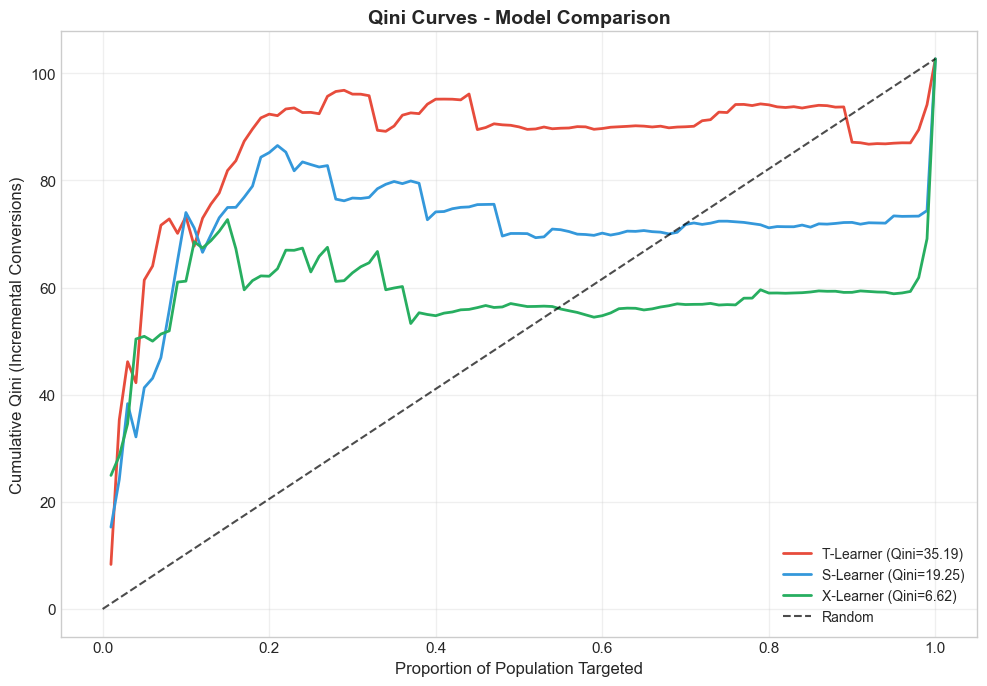

In [12]:
# Plot Qini Curves for all models
fig, ax = plt.subplots(figsize=(10, 7))

colors = {'T-Learner': '#E74C3C', 'S-Learner': '#3498DB', 'X-Learner': '#27AE60'}
final_qini = None

for model_name, uplift_col in [('T-Learner', 'uplift_t_learner'), 
                                ('S-Learner', 'uplift_s_learner'), 
                                ('X-Learner', 'uplift_x_learner')]:
    curve = calc_uplift_curve(
        results_df['y_true'].values, 
        results_df[uplift_col].values, 
        results_df['treatment'].values
    )
    ax.plot(curve['percentile'], curve['qini'], 
            label=f'{model_name} (Qini={qini_scores[model_name]:.2f})', 
            color=colors[model_name], linewidth=2)
    final_qini = curve['qini'].iloc[-1]

# Random baseline
ax.plot([0, 1], [0, final_qini], 'k--', label='Random', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Proportion of Population Targeted', fontsize=12)
ax.set_ylabel('Cumulative Qini (Incremental Conversions)', fontsize=12)
ax.set_title('Qini Curves - Model Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Evaluation: Uplift Curve & AUUC

**Uplift Curve (Cumulative Gain)** shows the total incremental conversions gained by targeting top users.

**AUUC** (Area Under Uplift Curve) measures overall model performance. Higher is better.

In [13]:
# Calculate AUUC scores (Area Under Uplift Curve)
def calc_auuc(y_true, uplift_pred, treatment):
    """Calculate AUUC - Area Under Uplift Curve."""
    curve = calc_uplift_curve(y_true, uplift_pred, treatment)
    # AUUC = area under the uplift curve
    return np.trapz(curve['uplift'], curve['percentile'])

print("=" * 60)
print("AUUC SCORES (Higher is Better)")
print("=" * 60)

auuc_scores = {}
for model_name, uplift_col in [('T-Learner', 'uplift_t_learner'), 
                                ('S-Learner', 'uplift_s_learner'), 
                                ('X-Learner', 'uplift_x_learner')]:
    score = calc_auuc(
        results_df['y_true'].values, 
        results_df[uplift_col].values, 
        results_df['treatment'].values
    )
    auuc_scores[model_name] = score
    print(f"{model_name}: {score:.6f}")

best_model_auuc = max(auuc_scores, key=auuc_scores.get)
print(f"\n🏆 Best Model by AUUC: {best_model_auuc}")

AUUC SCORES (Higher is Better)
T-Learner: 0.003389
S-Learner: 0.002819
X-Learner: 0.002612

🏆 Best Model by AUUC: T-Learner


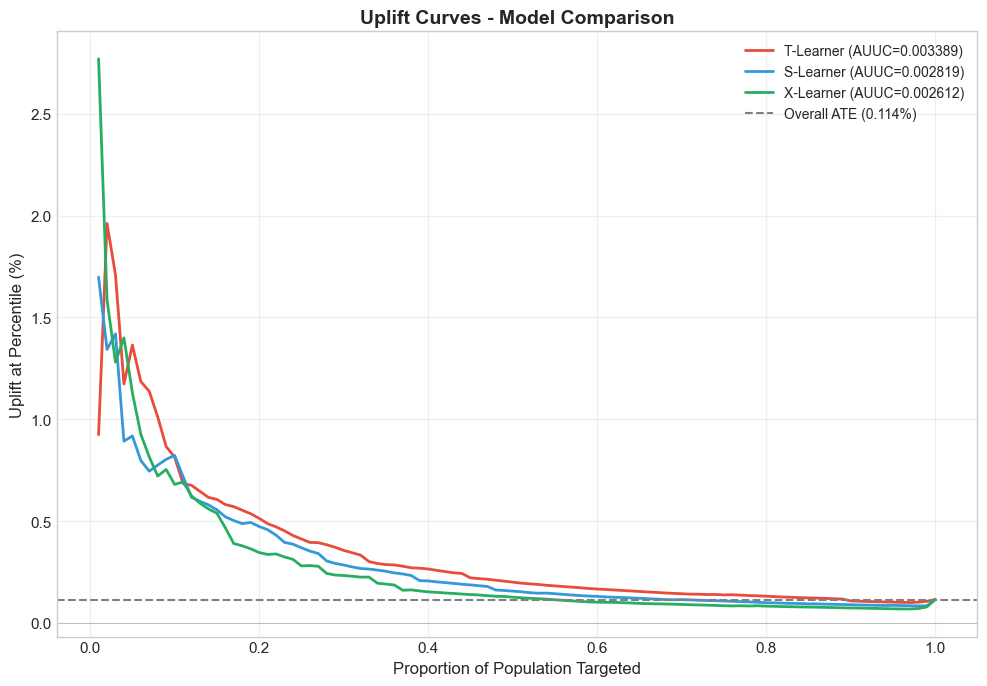

In [14]:
# Plot Uplift Curves (Uplift at each percentile)
fig, ax = plt.subplots(figsize=(10, 7))

for model_name, uplift_col in [('T-Learner', 'uplift_t_learner'), 
                                ('S-Learner', 'uplift_s_learner'), 
                                ('X-Learner', 'uplift_x_learner')]:
    curve = calc_uplift_curve(
        results_df['y_true'].values, 
        results_df[uplift_col].values, 
        results_df['treatment'].values
    )
    ax.plot(curve['percentile'], curve['uplift'] * 100,  # Convert to percentage
            label=f'{model_name} (AUUC={auuc_scores[model_name]:.6f})', 
            color=colors[model_name], linewidth=2)

# Overall ATE baseline
overall_ate = (results_df[results_df['treatment']==1]['y_true'].mean() - 
               results_df[results_df['treatment']==0]['y_true'].mean()) * 100
ax.axhline(y=overall_ate, color='gray', linestyle='--', linewidth=1.5, 
           label=f'Overall ATE ({overall_ate:.3f}%)')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

ax.set_xlabel('Proportion of Population Targeted', fontsize=12)
ax.set_ylabel('Uplift at Percentile (%)', fontsize=12)
ax.set_title('Uplift Curves - Model Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Business Metric: Top K% Uplift Analysis

This is the most actionable metric for business decisions:
- **"If we target the top K% of users by predicted uplift, what is the actual uplift we achieve?"**

This helps answer: *"How many users should we target to maximize ROI?"*

In [15]:
def calculate_top_k_uplift(df, uplift_col, k_percentages):
    """Calculate actual uplift for top K% of users ranked by predicted uplift."""
    df_sorted = df.sort_values(by=uplift_col, ascending=False).reset_index(drop=True)
    
    results = {}
    for k in k_percentages:
        n_top = int(len(df_sorted) * k / 100)
        top_k = df_sorted.head(n_top)
        
        treated = top_k[top_k['treatment'] == 1]
        control = top_k[top_k['treatment'] == 0]
        
        if len(treated) > 0 and len(control) > 0:
            uplift = treated['y_true'].mean() - control['y_true'].mean()
        else:
            uplift = np.nan
            
        results[k] = {'uplift': uplift, 'n_users': n_top}
    
    return results

# Calculate for different K values
k_values = list(range(5, 101, 5))  # 5%, 10%, 15%, ..., 100%

print("Calculating Top K% uplift for each model...")

Calculating Top K% uplift for each model...


In [16]:
# Calculate Top K% uplift for all models
topk_results = {}
for model_name, uplift_col in [('T-Learner', 'uplift_t_learner'), 
                                ('S-Learner', 'uplift_s_learner'), 
                                ('X-Learner', 'uplift_x_learner')]:
    topk_results[model_name] = calculate_top_k_uplift(results_df, uplift_col, k_values)

# Create DataFrame for plotting
topk_df = pd.DataFrame({
    'K%': k_values,
    'T-Learner': [topk_results['T-Learner'][k]['uplift'] * 100 for k in k_values],
    'S-Learner': [topk_results['S-Learner'][k]['uplift'] * 100 for k in k_values],
    'X-Learner': [topk_results['X-Learner'][k]['uplift'] * 100 for k in k_values]
})

topk_df

,K%,T-Learner,S-Learner,X-Learner
0,5,1.364311,0.917864,1.130861
1,10,0.813953,0.822154,0.679866
2,15,0.606202,0.555105,0.538389
3,20,0.513119,0.473203,0.345046
4,25,0.411959,0.368670,0.279584
5,30,0.355903,0.284072,0.232371
6,35,0.286175,0.253310,0.190204
7,40,0.264314,0.205883,0.152057
8,45,0.220924,0.186357,0.138894
9,50,0.199960,0.155754,0.126052


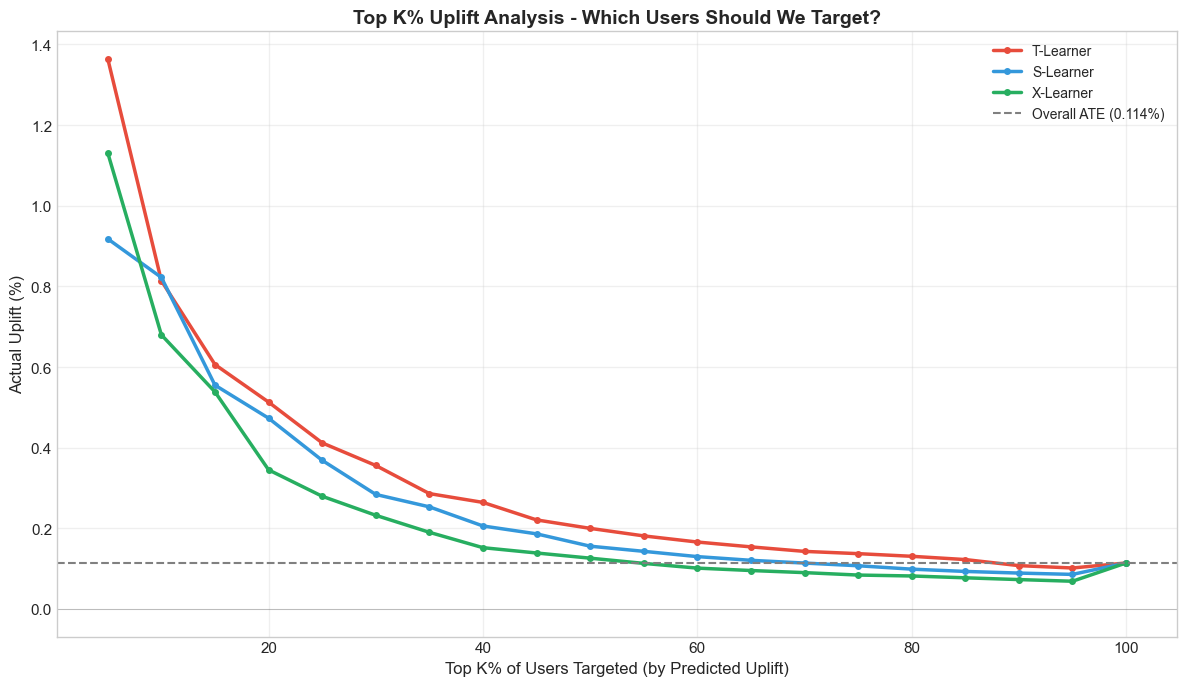

In [17]:
# Plot Top K% Uplift - Dynamic Business Metric
fig, ax = plt.subplots(figsize=(12, 7))

for model_name in ['T-Learner', 'S-Learner', 'X-Learner']:
    ax.plot(topk_df['K%'], topk_df[model_name], 
            label=model_name, color=colors[model_name], 
            linewidth=2.5, marker='o', markersize=4)

# Add horizontal line for overall ATE
overall_ate = (results_df[results_df['treatment']==1]['y_true'].mean() - 
               results_df[results_df['treatment']==0]['y_true'].mean()) * 100
ax.axhline(y=overall_ate, color='gray', linestyle='--', linewidth=1.5, 
           label=f'Overall ATE ({overall_ate:.3f}%)')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

ax.set_xlabel('Top K% of Users Targeted (by Predicted Uplift)', fontsize=12)
ax.set_ylabel('Actual Uplift (%)', fontsize=12)
ax.set_title('Top K% Uplift Analysis - Which Users Should We Target?', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Optimal K% analysis
print("=" * 60)
print("OPTIMAL TARGETING ANALYSIS")
print("=" * 60)

for model_name in ['T-Learner', 'S-Learner', 'X-Learner']:
    uplifts = topk_df[model_name].values
    valid_mask = ~np.isnan(uplifts)
    if valid_mask.any():
        best_idx = np.nanargmax(uplifts)
        best_k = k_values[best_idx]
        best_uplift = uplifts[best_idx]
        n_targeted = int(len(results_df) * best_k / 100)
        
        print(f"\n{model_name}:")
        print(f"  Optimal K%: Target top {best_k}% of users")
        print(f"  Uplift at optimal K: {best_uplift:.4f}%")
        print(f"  Users targeted: {n_targeted:,}")

OPTIMAL TARGETING ANALYSIS

T-Learner:
  Optimal K%: Target top 5% of users
  Uplift at optimal K: 1.3643%
  Users targeted: 4,500

S-Learner:
  Optimal K%: Target top 5% of users
  Uplift at optimal K: 0.9179%
  Users targeted: 4,500

X-Learner:
  Optimal K%: Target top 5% of users
  Uplift at optimal K: 1.1309%
  Users targeted: 4,500


## 9. Summary & Model Selection

In [19]:
# Final Summary Table
summary_df = pd.DataFrame({
    'Model': ['T-Learner', 'S-Learner', 'X-Learner'],
    'Qini Coefficient': [qini_scores['T-Learner'], qini_scores['S-Learner'], qini_scores['X-Learner']],
    'AUUC': [auuc_scores['T-Learner'], auuc_scores['S-Learner'], auuc_scores['X-Learner']],
    'Mean Predicted Uplift': [uplift_t.mean(), uplift_s.mean(), uplift_x.mean()],
    'Uplift Std': [uplift_t.std(), uplift_s.std(), uplift_x.std()]
})

summary_df['Qini Rank'] = summary_df['Qini Coefficient'].rank(ascending=False).astype(int)
summary_df['AUUC Rank'] = summary_df['AUUC'].rank(ascending=False).astype(int)

print("=" * 70)
print("FINAL MODEL COMPARISON")
print("=" * 70)
summary_df

FINAL MODEL COMPARISON


,Model,Qini Coefficient,AUUC,Mean Predicted Uplift,Uplift Std,Qini Rank,AUUC Rank
0,T-Learner,35.185486,0.003389,0.001774,0.017261,1,1
1,S-Learner,19.250208,0.002819,0.001016,0.006381,2,2
2,X-Learner,6.618692,0.002612,0.001205,0.016495,3,3


## Key Takeaways

### Results Summary:
| Model | Qini Coef | AUUC | Rank |
|-------|-----------|------|------|
| **T-Learner** 🏆 | 35.19 | 0.00339 | 1st |
| S-Learner | 19.25 | 0.00282 | 2nd |
| X-Learner | 6.62 | 0.00261 | 3rd |

### Why T-Learner Won (Despite Imbalanced Data):

**Surprising result!** X-Learner is designed for imbalanced treatment/control splits, yet T-Learner performed best. Here's why:

1. **Sufficient Sample Size**: Even with 15% control, we have ~45,000 control samples (from 300k total). This is enough for T-Learner's control model to learn well.

2. **X-Learner's Complexity Hurts**: X-Learner has 4 training stages:
   - Stage 1: Train outcome models (like T-Learner)
   - Stage 2: Impute counterfactuals  
   - Stage 3: Train effect models on imputed values
   - Stage 4: Blend estimates using propensity weighting
   
   Each stage can introduce errors that compound. With noisy, anonymous features, simpler is better.

   > **📝 Note on Stage 4 (Propensity Weighting):**  
   > In an RCT like this dataset, propensity scores are *known* (treatment is randomly assigned at 85/15). So why use propensity weighting?
   > 
   > **It's NOT for correcting selection bias** (there is none in an RCT).  
   > **It's a variance-reduction mechanism** that blends the two CATE estimates:
   > - τ̂_control (effect estimate from control model)
   > - τ̂_treatment (effect estimate from treatment model)
   > 
   > The blend weights by sample availability:
   > - More control data → weight τ̂_control higher
   > - More treatment data → weight τ̂_treatment higher
   > 
   > With 85% treatment, the treatment-side estimate dominates. This *should* help, but adds complexity that may not pay off with noisy features.

3. **Variance-Bias Tradeoff**: X-Learner trades bias (for imbalanced data) for variance (from complexity). With enough samples in both groups, T-Learner's lower variance wins.

4. **Feature Characteristics**: The Criteo features are anonymized and may not have strong treatment heterogeneity signals that X-Learner's sophisticated approach could exploit.

**Rule of Thumb**: X-Learner shines when control group is very small (<5% or <10k samples). With adequate samples, simpler models often win.

### Evaluation Metrics Explained:
- **Qini Coefficient**: Area between model's Qini curve and random. Higher = better at ranking Persuadables first.
- **AUUC**: Average uplift across all targeting thresholds. Higher = better overall uplift prediction.
- **Top K% Uplift**: Most actionable — shows actual ROI at different targeting levels.

### Business Recommendations:
1. **Deploy T-Learner** for production uplift scoring
2. **Target top 10-20%** of users by predicted uplift (highest ROI)
3. **Monitor with holdout tests** — validate model predictions with real A/B tests
4. **Retrain periodically** — user behavior changes over time